# PDOS Plotting for g-BC3

Projected electronic density versus energy

## Projected electronic density versus energy


In [1]:
#### Analyze the data structure

import xml.etree.ElementTree as ET

# File path (update this to the correct file path)
pdos_file_path = "4_PDOS_gamma/vasprun.xml"

def analyze_vasprun(file_path):
    # Parse the vasprun.xml file
    tree = ET.parse(file_path)
    root = tree.getroot()
    # Flags to keep track of <ion 1> and <spin 1>
    ion_1_found = False
    spin_1_count = 0
    # Loop through <set> elements
    for set_element in root.findall(".//set"):
        comment = set_element.attrib.get("comment", "")
        # Track when <ion 1> is found
        if "ion 1" in comment:
            ion_1_found = True
        # Count <spin 1> only after <ion 1> is found
        if ion_1_found and "spin 1" in comment:
            spin_1_count += 1
            # Skip the first <spin 1> after <ion 1> is found
            if spin_1_count == 1:
                continue
            # Loop through the <r> elements and print the number of values and the values themselves
            for i, r_element in enumerate(set_element.findall("r")):
                values = list(map(float, r_element.text.split()))
                print(f"Number of values in row {i + 1}: {len(values)}")
                print(f"Values: {values}")
            # Break the loop after analyzing the second occurrence of <spin 1>
            break

# analyze_vasprun(pdos_file_path)


In [2]:
#### Declarations of process functions for PDOS with vectorized programming

### Necessary packages invoking
import numpy as np
import xml.etree.ElementTree as ET

### Extract PDOS from vasprun.xml
def extract_pdos_vectorized(file_path):
    ## Analysis vasprun.xml file
    tree = ET.parse(file_path)
    root = tree.getroot()

    ## Extract Fermi energy
    efermi_element = root.find(".//dos/i[@name='efermi']")
    efermi = float(efermi_element.text.strip())

    ## Extract the number of ions
    first_positions = root.find(".//varray[@name='positions'][1]")
    positions_concatenated_text = " ".join([position.text for position in first_positions.findall("v")])
    positions_array = np.fromstring(positions_concatenated_text, sep=" ")
    positions_matrix = positions_array.reshape(-1, 3)
    ions_number = positions_matrix.shape[0]   

    ## Extract the number of kpoints
    kpointlist = root.find(".//varray[@name='kpointlist']")
    kpointlist_concatenated_text = " ".join([kpointlist.text for kpointlist in kpointlist.findall("v")])
    kpointlist_array = np.fromstring(kpointlist_concatenated_text, sep=" ")
    kpointlist_matrix = kpointlist_array.reshape(-1, 3)
    kpoints_number = kpointlist_matrix.shape[0] 

    ## Extract eigen, occupancy number
    for kpoints_index in range(1, kpoints_number + 1):
        xpath_expr = f".//set[@comment='kpoint {kpoints_index}']"
        eigen_column = np.empty(0)
        occu_column  = np.empty(0)
        for eigen_occ_element in root.find(xpath_expr):
            eigen_values = list(map(float, eigen_occ_element.text.split()))
            eigen_column = np.append(eigen_column, eigen_values[0])
            occu_column = np.append(occu_column, eigen_values[1])
        if kpoints_index == 1 :
            eigen_matrix = eigen_column.reshape(-1, 1)
            occu_matrix = occu_column.reshape(-1, 1)
        else:
            eigen_matrix = np.hstack((eigen_matrix,eigen_column.reshape(-1, 1)))
            occu_matrix  = np.hstack((occu_matrix, occu_column.reshape(-1, 1)))
    # eigen_sum = np.sum(eigen_matrix, axis=1)
    # occu_sum  = np.sum(occu_matrix, axis=1)

    ## Extract energy, total DOS, and integrated DOS
    # lists initialization
    energy_dos_list     = np.empty(0)
    total_dos_list      = np.empty(0)
    integrated_dos_list = np.empty(0)
    path_dos = f".//total/array/set/set[@comment='spin 1']/r"
    for element_dos in root.findall(path_dos):
        dos_values = list(map(float, element_dos.text.split()))
        energy_var = dos_values[0]
        energy_dos_list = np.append(energy_dos_list, energy_var)
        total_dos_var = dos_values[1]
        total_dos_list = np.append(total_dos_list, total_dos_var)
        integrated_dos_var = dos_values[2]
        integrated_dos_list = np.append(integrated_dos_list, integrated_dos_var)
    shift = efermi
    energy_dos_shift = energy_dos_list - shift

    ## Extract energy, s-PDOS, p_y-PDOS, p_z-PDOS, p_x-PDOS, d_xy-PDOS, d_yz-PDOS, d_z2-PDOS, d_xz-PDOS, x2-y2-PDOS
    # Matrices initialization
    for ions_index in range(1, ions_number + 1):
        path_ions = f".//set[@comment='ion {ions_index}']/set[@comment='spin 1']/r"
        # Columns initialization
        energy_pdos_column  = np.empty(0)
        s_pdos_column       = np.empty(0)
        p_y_pdos_column     = np.empty(0)
        p_z_pdos_column     = np.empty(0)
        p_x_pdos_column     = np.empty(0)
        d_xy_pdos_column    = np.empty(0)
        d_yz_pdos_column    = np.empty(0)
        d_z2_pdos_column    = np.empty(0)
        d_xz_pdos_column    = np.empty(0)
        x2_y2_pdos_column   = np.empty(0)
        for pdos_element in root.findall(path_ions):
            pdos_values = list(map(float, pdos_element.text.split()))
            # Columns of energy
            energy_pdos_column = np.append(energy_pdos_column, pdos_values[0])
            # Columns of s-PDOS
            s_pdos_column = np.append(s_pdos_column, pdos_values[1])
            # Columns of p_y-PDOS
            p_y_pdos_column = np.append(p_y_pdos_column, pdos_values[2])
            # Columns of p_z-PDOS
            p_z_pdos_column = np.append(p_z_pdos_column, pdos_values[3])
            # Columns of p_x-PDOS
            p_x_pdos_column = np.append(p_x_pdos_column, pdos_values[4])
            # Columns of d_xy-PDOS
            d_xy_pdos_column = np.append(d_xy_pdos_column, pdos_values[5])
            # Columns of d_yz-PDOS
            d_yz_pdos_column = np.append(d_yz_pdos_column, pdos_values[6])
            # Columns of d_z2-PDOS
            d_z2_pdos_column = np.append(d_z2_pdos_column, pdos_values[7])
            # Columns of d_xz-PDOS
            d_xz_pdos_column = np.append(d_xz_pdos_column, pdos_values[8])
            # Columns of x2-y2-PDOS
            x2_y2_pdos_column = np.append(x2_y2_pdos_column, pdos_values[9])
        if ions_index == 1:
            energy_pdos_matrix = energy_pdos_column.reshape(-1, 1)
            s_pdos_matrix = s_pdos_column.reshape(-1, 1)
            p_y_pdos_matrix = p_y_pdos_column.reshape(-1, 1)
            p_z_pdos_matrix = p_z_pdos_column.reshape(-1, 1)
            p_x_pdos_matrix = p_x_pdos_column.reshape(-1, 1)
            d_xy_pdos_matrix = d_xy_pdos_column.reshape(-1, 1)
            d_yz_pdos_matrix = d_yz_pdos_column.reshape(-1, 1)
            d_z2_pdos_matrix = d_z2_pdos_column.reshape(-1, 1)
            d_xz_pdos_matrix = d_xz_pdos_column.reshape(-1, 1)
            x2_y2_pdos_matrix = x2_y2_pdos_column.reshape(-1, 1)
        else:
            energy_pdos_matrix = np.hstack((energy_pdos_matrix, energy_pdos_column.reshape(-1, 1)))
            s_pdos_matrix = np.hstack((s_pdos_matrix, s_pdos_column.reshape(-1, 1)))
            p_y_pdos_matrix = np.hstack((p_y_pdos_matrix, p_y_pdos_column.reshape(-1, 1)))
            p_z_pdos_matrix = np.hstack((p_z_pdos_matrix, p_z_pdos_column.reshape(-1, 1)))
            p_x_pdos_matrix = np.hstack((p_x_pdos_matrix, p_x_pdos_column.reshape(-1, 1)))
            d_xy_pdos_matrix = np.hstack((d_xy_pdos_matrix, d_xy_pdos_column.reshape(-1, 1)))
            d_yz_pdos_matrix = np.hstack((d_yz_pdos_matrix, d_yz_pdos_column.reshape(-1, 1)))
            d_z2_pdos_matrix = np.hstack((d_z2_pdos_matrix, d_z2_pdos_column.reshape(-1, 1)))
            d_xz_pdos_matrix = np.hstack((d_xz_pdos_matrix, d_xz_pdos_column.reshape(-1, 1)))
            x2_y2_pdos_matrix = np.hstack((x2_y2_pdos_matrix, x2_y2_pdos_column.reshape(-1, 1)))
    energy_pdos_sum = energy_pdos_matrix[:,0]
    s_pdos_sum = np.sum(s_pdos_matrix, axis=1)
    p_y_pdos_sum = np.sum(p_y_pdos_matrix, axis=1)
    p_z_pdos_sum = np.sum(p_z_pdos_matrix, axis=1)
    p_x_pdos_sum = np.sum(p_x_pdos_matrix, axis=1)
    d_xy_pdos_sum = np.sum(d_xy_pdos_matrix, axis=1)
    d_yz_pdos_sum = np.sum(d_yz_pdos_matrix, axis=1)
    d_z2_pdos_sum = np.sum(d_z2_pdos_matrix, axis=1)
    d_xz_pdos_sum = np.sum(d_xz_pdos_matrix, axis=1)
    x2_y2_pdos_sum = np.sum(x2_y2_pdos_matrix, axis=1)
    energy_pdos_shift = energy_pdos_sum - shift
    return (efermi, ions_number, kpoints_number, eigen_matrix, occu_matrix,             # 0 ~ 4
            energy_dos_shift, total_dos_list, integrated_dos_list,                      # 5 ~ 7
            energy_pdos_shift, s_pdos_sum, p_y_pdos_sum, p_z_pdos_sum, p_x_pdos_sum,    # 8 ~ 12
            d_xy_pdos_sum, d_yz_pdos_sum, d_z2_pdos_sum, d_xz_pdos_sum,                 # 13 ~ 16
            x2_y2_pdos_sum)


In [3]:
##### Data Process

### File path (you should update this to the correct file path)
pdos_file_path = "4_PDOS_gamma/vasprun.xml"

### Extract data
pdos_results = extract_pdos_vectorized(pdos_file_path)
## Physical contents
efermi_pdos = pdos_results[0]
## DOS
energy_dos_shift = pdos_results[5]
total_dos_list = pdos_results[6]
## PDOS
energy_pdos_shift = pdos_results[8]
s_pdos_sum = pdos_results[9]
p_y_pdos_sum = pdos_results[10]
p_z_pdos_sum = pdos_results[11]
p_x_pdos_sum = pdos_results[12]

## Testing space
# print(f"energy_dos_shift: {len(energy_dos_shift)}{energy_dos_shift[0:10]}")
# print(f"energy_pdos_shift: {len(energy_pdos_shift)}{energy_pdos_shift[0:10]} ")

print(f"first eigen column: {pdos_results[3][:,0]}")


first eigen column: [-18.5405 -14.649  -14.6489 -12.2992 -12.2992 -11.2308  -9.9134  -7.3453
  -7.125   -4.971   -4.971   -3.1494  -3.1493  -2.4667  -2.4666  -0.6314
   1.1011   1.1011   1.7906   1.9212   4.5207   5.9119   6.3151   6.3151]


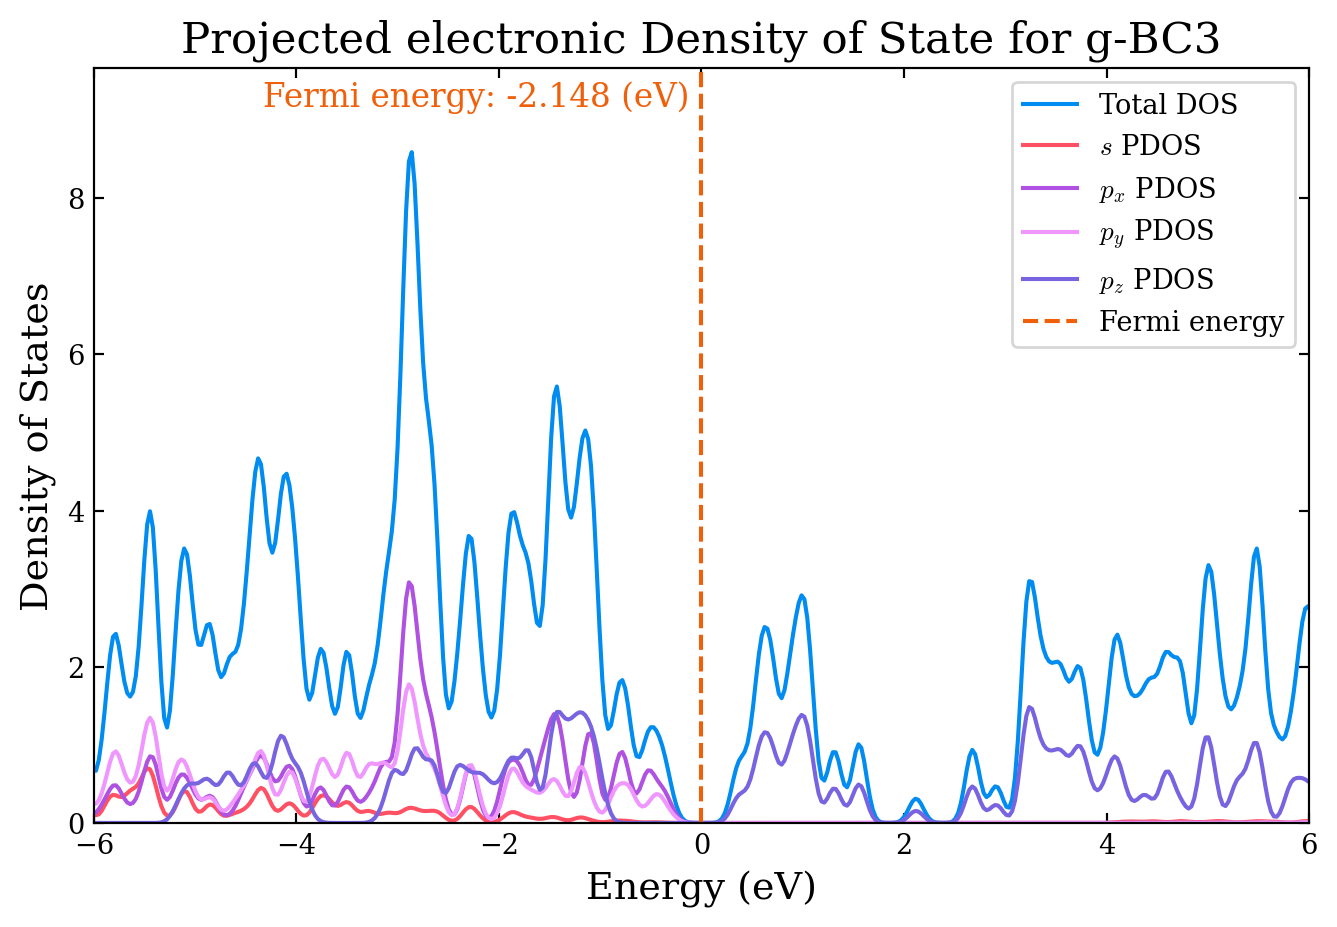

1000


In [5]:
#### Ploting for PDOS

### Import the necessary packages for plotting
import matplotlib.pyplot as plt
import numpy as np

### Set up the specified style parameters
plt.figure(dpi=196, figsize=(8, 5))
params = {"text.usetex": False, "font.family": "serif", "mathtext.fontset": "cm", "axes.titlesize": 16, "axes.labelsize": 14, "figure.facecolor": "w"}
plt.rcParams.update(params)
plt.tick_params(direction="in", which="both", top=True, right=True, bottom=True, left=True)

### Title and labels
plt.title("Projected electronic Density of State for g-BC3"); plt.xlabel(r"Energy (eV)"); plt.ylabel(r"Density of States")

### Process the data
## DOS
energy_dos_array = np.array(energy_dos_shift)
total_dos_array = np.array(total_dos_list)
## PDOS
energy_pdos_array = np.array(energy_pdos_shift)
s_pdos_array = np.array(s_pdos_sum)
p_y_pdos_array = np.array(p_y_pdos_sum)
p_z_pdos_array = np.array(p_z_pdos_sum)
p_x_pdos_array = np.array(p_x_pdos_sum)

max_value = np.max([total_dos_array, s_pdos_array, p_y_pdos_array, p_z_pdos_array, p_x_pdos_array])

## Plot data
# Plot PDOS data from vasprun.xml
y_axis_top = max_value
y_limit = y_axis_top * 1.125
x_range = 6

# Plot DOS
plt.plot(energy_dos_array, total_dos_array, c="#008CF0", label=r"Total DOS")

# Plot PDOS
plt.plot(energy_pdos_array,   s_pdos_array, c="#FF5064", label=r"$s$ PDOS")
plt.plot(energy_pdos_array, p_x_pdos_array, c="#AF51E1", label=r"$p_x$ PDOS")
plt.plot(energy_pdos_array, p_y_pdos_array, c="#F096FF", label=r"$p_y$ PDOS")
plt.plot(energy_pdos_array, p_z_pdos_array, c="#7864E1", label=r"$p_z$ PDOS")

# Plot Fermi energy as a vertical line
shift = efermi_pdos
plt.axvline(x = efermi_pdos-shift, linestyle="--", color="#F05F0A", label=r"Fermi energy")

# Add Fermi energy value to the plot
fermi_energy_text = f"Fermi energy: {efermi_pdos:.3f} (eV)"
plt.text(efermi_pdos-shift-x_range*0.02, y_limit*0.95, fermi_energy_text, fontsize=12, color="#F05F0A", rotation=0, ha="right")

plt.ylim(0, y_limit)
plt.xlim(-x_range, x_range)
plt.legend(loc="best")

plt.show()

print(len(energy_pdos_array))
